In [1]:
import time
import matplotlib as plt
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import json

In [2]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class FancyJECL2L3Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        eta_axis = hist.Bin("eta", r"$\eta$", 20, -5, 5)
        pt_reco_axis = hist.Bin("pt_reco_axis", r"$Reco p_{T}$ [GeV]", 
                           np.array([0,5,10,15,20,25,30,35,40,45,50,60,70,80,90,
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000,4000,5000]))
        pt_gen_axis = hist.Bin("pt_gen_axis", r"$Gen p_{T}$ [GeV]", 
                           np.array([0,5,10,15,20,25,30,35,40,45,50,60,70,80,90,
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000,4000,5000]))
        m_reco_axis = hist.Bin("m_reco_axis", r" Reco $m$ [GeV]", 20, 0, 1000)
        m_gen_axis = hist.Bin("m_gen_axis", r"Gen $m$ [GeV]", 20, 0, 1000)
        #gen_axis = hist.Bin("gen_axis", r"Gen?", 0,100, 20)
        #reco_axis = hist.Bin("reco_axis", r"Reco?", 0,100, 20)

        
        self._accumulator = processor.dict_accumulator({
            'pt':hist.Hist("Counts", dataset_axis, pt_reco_axis),
            'm':hist.Hist("Counts", dataset_axis, m_reco_axis),
            'h_reco_pt_m':hist.Hist("Counts", dataset_axis, pt_reco_axis, m_reco_axis),
            'h_gen_pt_m':hist.Hist("Counts", dataset_axis, pt_gen_axis, m_gen_axis),
            'h_response':hist.Hist("Counts", dataset_axis, pt_gen_axis, pt_reco_axis, m_gen_axis, m_reco_axis),
            #'h_2dresponse':hist.Hist("Counts", dataset_axis, gen_axis, reco_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()

#         print("1")
        dataset = df['dataset']
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'],
            eta=df['FatJet_eta'],
            phi=df['FatJet_phi'],
            mass=df['FatJet_mass'],
            jetId=df['FatJet_jetId']
            )        
        
        GenJets = JaggedCandidateArray.candidatesfromcounts(
            df['nGenJet'],
            pt=df['GenJet_pt'],
            eta=df['GenJet_eta'],
            phi=df['GenJet_phi'],
            mass=df['GenJet_mass']
            )
        
        
        evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        output['cutflow']['all events'] += Jets.size

        jetId_cut = (Jets.jetId > 0)        
        Jets = Jets[jetId_cut]
        output['cutflow']['>=1 with loose id'] += jetId_cut.any().sum()
        twoJets_cut = (Jets.counts >= 2)        
        output['cutflow']['>=2 reco jets'] += twoJets_cut.sum()
        twoGens_cut = (GenJets.counts >= 2)
        output['cutflow']['>=2 gen jets'] += twoGens_cut.sum()
        

        twoJets = Jets[twoJets_cut]
        twoGenJets = GenJets[twoGens_cut]
        
        dphi_index_reco = twoJets.p4[:,0].delta_phi( twoJets.p4[:,1] ) > np.pi/2
        dphi_index_gen = twoGenJets.p4[:,0].delta_phi( twoGenJets.p4[:,1] ) > np.pi/2
        #print('dphi_index shape', dphi_index.shape)
        #print('Jets shape', Jets.shape)
        #print('Gens shape', GenJets.shape)
        output['cutflow']['dPhi > Pi/2'] += dphi_index_reco.sum()
        output['cutflow']['dPhi Gen > Pi/2'] += dphi_index_gen.sum()
        
        
        #print('pt asymm')
        pt_asymm_index_reco = (twoJets.p4[:,0].pt -  twoJets.p4[:,1].pt )/(twoJets.p4[:,0].pt +  twoJets.p4[:,1].pt ) < 0.3
        pt_asymm_index_gen = (twoGenJets.p4[:,0].pt -  twoGenJets.p4[:,1].pt )/(twoGenJets.p4[:,0].pt +  
                                                                                twoGenJets.p4[:,1].pt ) < 0.3
        output['cutflow']['pt asymmetry < 0.3'] += pt_asymm_index_reco.sum()
        output['cutflow']['pt Asymmetry Gen < 0.3'] += pt_asymm_index_gen.sum()

        twoJets = twoJets[pt_asymm_index_reco & dphi_index_reco]
        twoGenJets = twoGenJets[pt_asymm_index_gen & dphi_index_gen]
        
#         print("Jets shape ", Jets.shape)
#         print("GenJets shape ", GenJets.shape)
        
        output['pt'].fill(dataset = dataset, pt_reco_axis = twoJets.pt.flatten())
        output['m'].fill(dataset = dataset, m_reco_axis = twoJets.mass.flatten())
        output['h_reco_pt_m'].fill(dataset = dataset, pt_reco_axis = twoJets.pt.flatten(),
                                   m_reco_axis = twoJets.mass.flatten().flatten())
        output['h_gen_pt_m'].fill(dataset = dataset, pt_gen_axis = twoGenJets.pt.flatten(), 
                                  m_gen_axis = twoGenJets.mass.flatten())
        
        Jets = Jets[twoJets_cut & twoGens_cut]
        GenJets = GenJets[twoJets_cut & twoGens_cut]
        
        
        dphi_index_reco = Jets.p4[:,0].delta_phi( Jets.p4[:,1] ) > np.pi/2
        dphi_index_gen = GenJets.p4[:,0].delta_phi( GenJets.p4[:,1] ) > np.pi/2
        pt_asymm_index_reco = (Jets.p4[:,0].pt -  Jets.p4[:,1].pt )/(Jets.p4[:,0].pt +  Jets.p4[:,1].pt ) < 0.3
        pt_asymm_index_gen = (GenJets.p4[:,0].pt -  GenJets.p4[:,1].pt )/(GenJets.p4[:,0].pt + GenJets.p4[:,1].pt ) < 0.3
        
        
        Jets = Jets[pt_asymm_index_reco & dphi_index_reco & pt_asymm_index_gen & dphi_index_gen]
        GenJets = GenJets[pt_asymm_index_reco & dphi_index_reco & pt_asymm_index_gen & dphi_index_gen]
        
        
        #print(GenJets.shape, dphi_index_gen.shape, pt_asymm_index_gen.shape, Jets.shape)
#         Jets = Jets[dphi_index_gen & pt_asymm_index_gen]
    
#         GenJets = GenJets[dphi_index_reco & pt_asymm_index_reco]

        pairing = Jets.p4[:,0:2].cross(GenJets.p4, nested=True)
        metric = pairing.i0.delta_r(pairing.i1)
#         print("pairing shape:", pairing.shape)
        
        index_of_minimized = metric.argmin()
        dr_cut = (metric[index_of_minimized] < 0.4)
        best_pairings_that_pass_dr_cut = pairing[index_of_minimized][dr_cut]
        genrecos = best_pairings_that_pass_dr_cut.flatten(axis=1)
        #print("genrecos shape:", genrecos.shape)
        #ptresponse = genrecos.i0.pt / genrecos.i1.pt
        
        #print(genrecos.i1.mass)
    
        output['h_response'].fill(dataset = dataset, pt_gen_axis = genrecos.i1.pt.flatten(), 
                                  pt_reco_axis = genrecos.i0.pt.flatten(),
                                  m_gen_axis = genrecos.i1.mass.flatten(), m_reco_axis = genrecos.i0.mass.flatten() )
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
   

# Get the sample metadata
samples = json.load( open('samples_qcdflat.json') )

prefix = '/mnt/data/cms/store/mc/RunIIFall17NanoAODv5/'
fileset = {}
for sample in samples["samples"]:    
    name, xsec, nevents = sample['name'], sample['xsec'], sample['nevents']
    fileset[name] = glob.glob(prefix + name + '/*/*/*/*.root')
    
    
tstart = time.time() 
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=FancyJECL2L3Processor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True},
                                  chunksize=500000,
                                 )


elapsed = time.time() - tstart
print(output)

4142.177
4033.273
3807.5967
3959.901
4693.9263
4282.6323
3955.8196
3920.4941
3981.0188
3615.9705
4181.3916
4211.7485
4146.3677
4269.239
3787.9875
4291.076
3590.8457
3784.4158
4486.356
4130.8804
3675.8071
3500.023
3974.0085
4666.377
3896.5193
3865.5137
3962.1406
3524.7988
4574.2583
3937.097
4512.0083
2827.8484
3375.4058
4062.2646
3731.6848
4053.4412
3904.8955
3707.671
3637.7583
4794.098
4047.2664
4332.4214
3884.4604
4337.5864

{'pt': <Hist (dataset,pt_reco_axis) instance at 0x7f23c8ab7dd8>, 'm': <Hist (dataset,m_reco_axis) instance at 0x7f23c8a89198>, 'h_reco_pt_m': <Hist (dataset,pt_reco_axis,m_reco_axis) instance at 0x7f23c8a89588>, 'h_gen_pt_m': <Hist (dataset,pt_gen_axis,m_gen_axis) instance at 0x7f23c8a89b38>, 'h_response': <Hist (dataset,pt_gen_axis,pt_reco_axis,m_gen_axis,m_reco_axis) instance at 0x7f23c8a89908>, 'h_2dresponse': <Hist (dataset,gen_axis,reco_axis) instance at 0x7f23c8a89eb8>, 'cutflow': defaultdict(<class 'int'>, {'all events': 18455107, '>=1 with loose id': 10092

In [4]:
import matplotlib.pyplot as plt

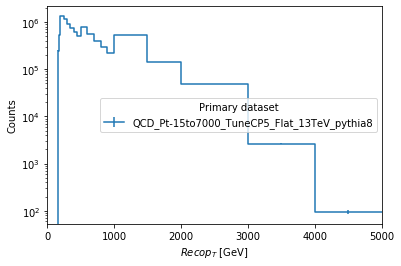

In [5]:
fig, ax = hist.plotgrid(output['pt'], overlay="dataset", stack=False
                    )
plt.yscale("log")
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

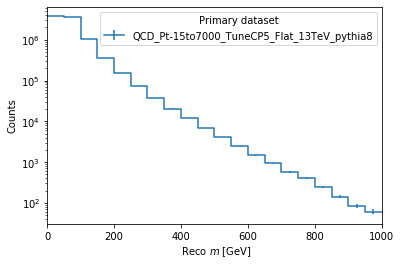

In [6]:
fig, ax = hist.plotgrid(output['m'], overlay="dataset", stack=False
                    )
plt.yscale("log")
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

<Hist (m_reco_axis) instance at 0x7f23c3233cf8>


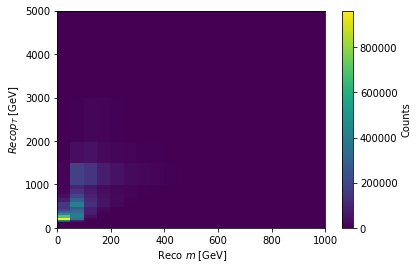

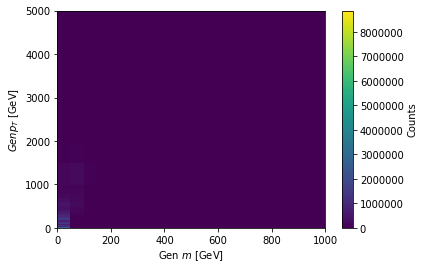

In [7]:
print(output['h_reco_pt_m'].sum('pt_reco_axis', 'dataset'))
hist.plot2d(output['h_reco_pt_m'].sum('dataset'), xaxis='m_reco_axis');
hist.plot2d(output['h_gen_pt_m'].sum('dataset'), xaxis='m_gen_axis');

<Hist (dataset,pt_gen_axis,pt_reco_axis,m_gen_axis,m_reco_axis) instance at 0x7f23c8a89908>


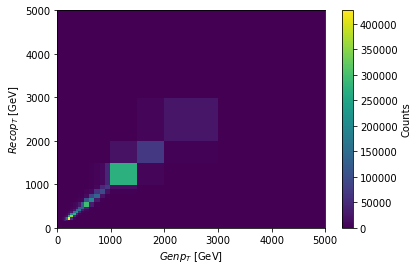

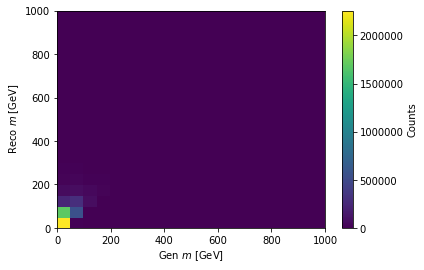

In [8]:
print(output['h_response'])
hist.plot2d(output['h_response'].sum('dataset', 'm_reco_axis', 'm_gen_axis'), xaxis='pt_gen_axis');
hist.plot2d(output['h_response'].sum('dataset', 'pt_reco_axis', 'pt_gen_axis'), xaxis='m_gen_axis');


/home/jovyan/coffea/coffea/hist/plot.py:430: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1)


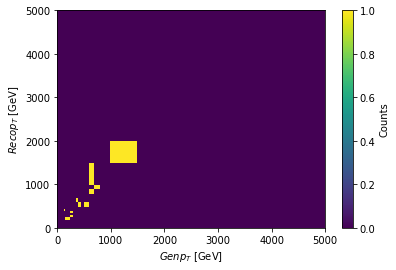

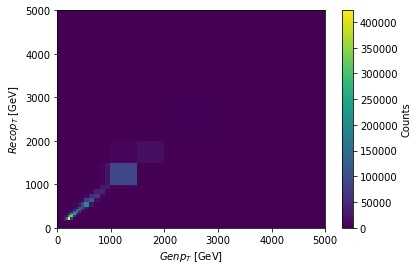

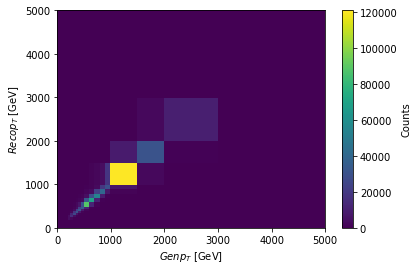

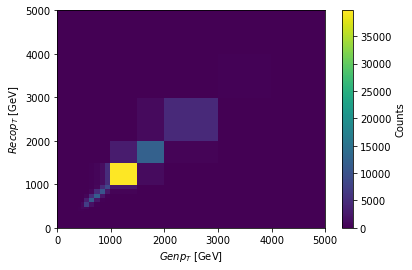

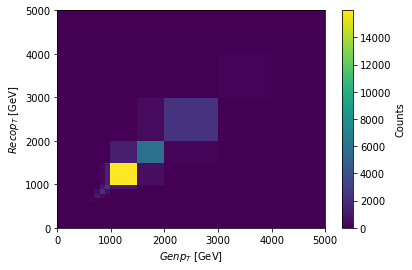

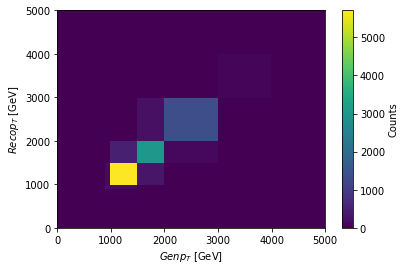

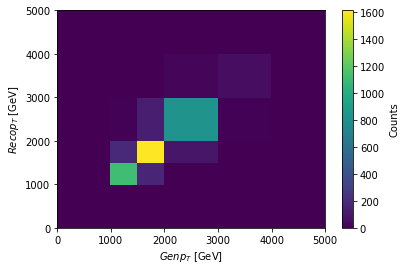

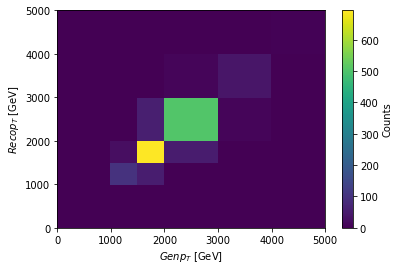

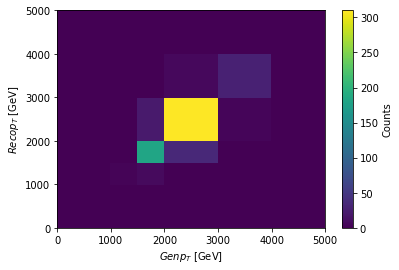

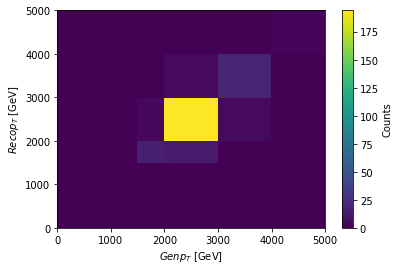

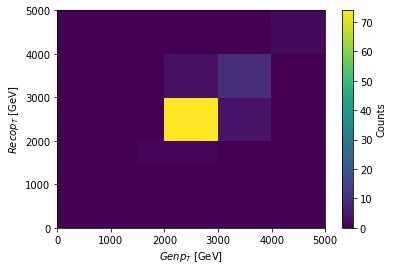

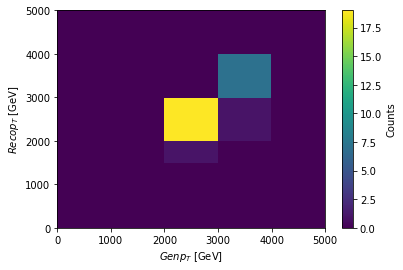

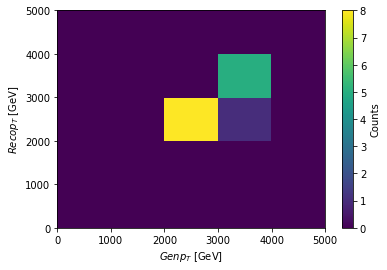

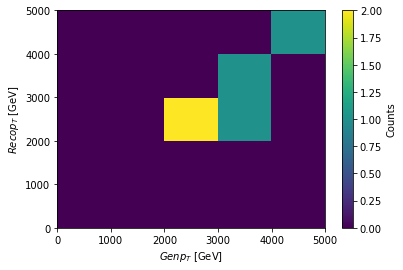

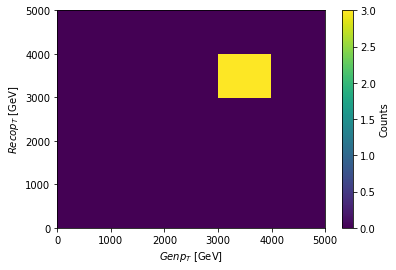

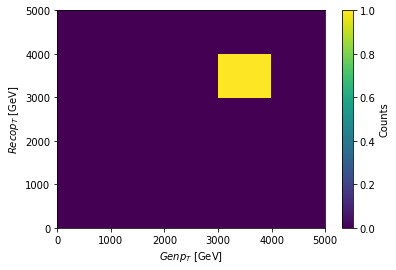

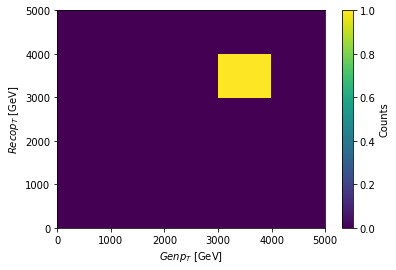

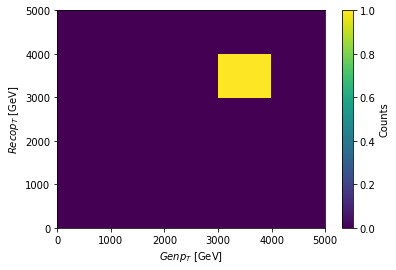

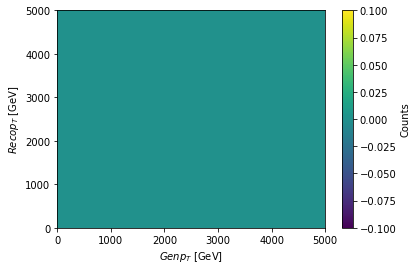

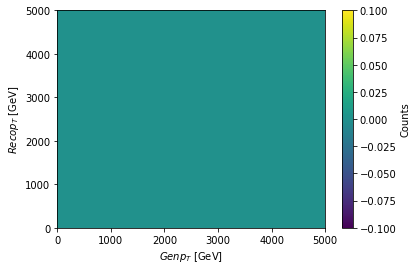

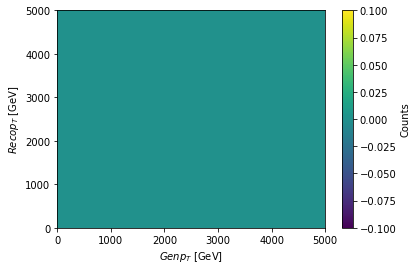

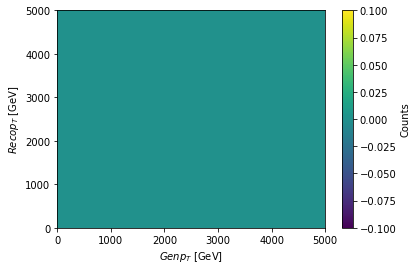

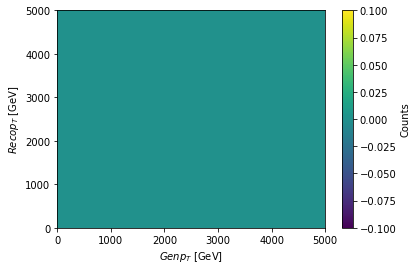

In [12]:
for i in output['h_response'].axis('m_gen_axis'):
    fig, ax, _ = hist.plot2d(output['h_response'].sum('dataset','m_reco_axis').integrate('m_gen_axis', i),xaxis='pt_gen_axis')

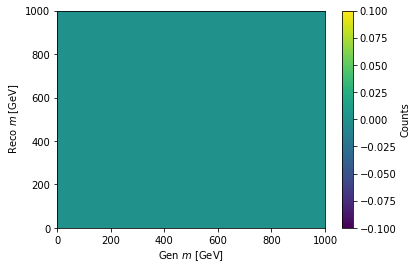

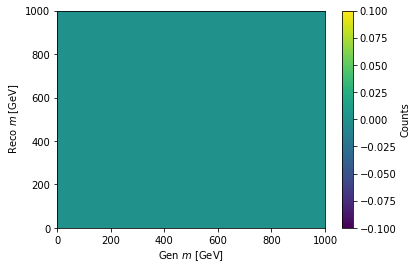

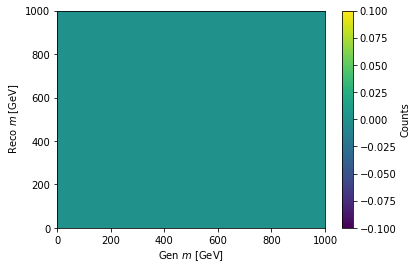

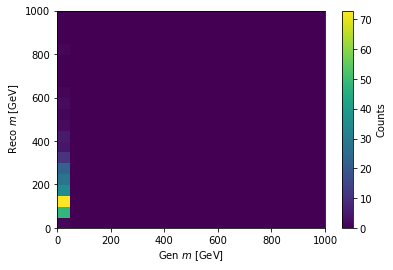

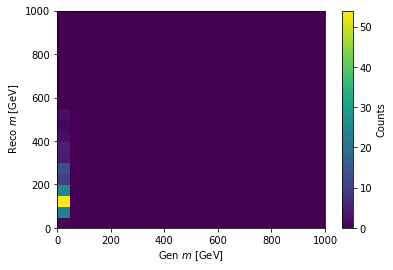

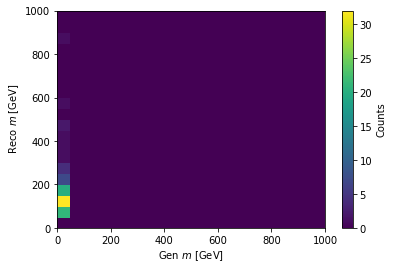

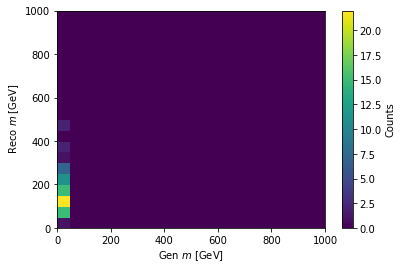

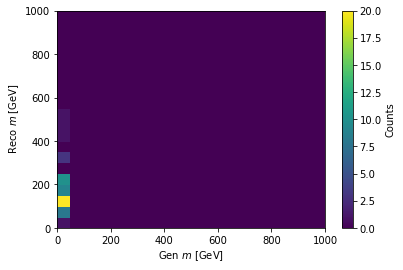

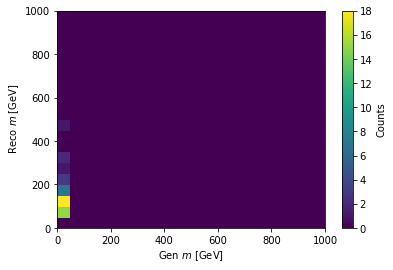

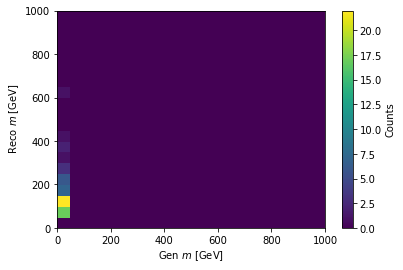

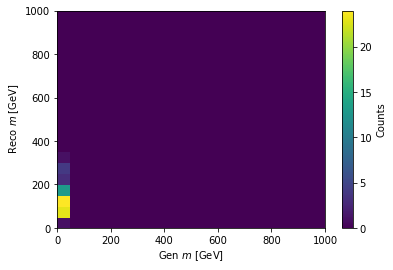

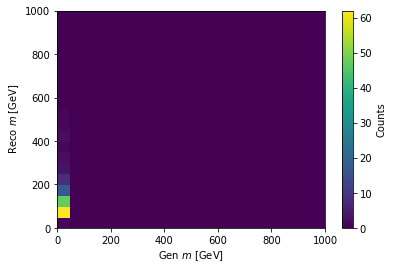

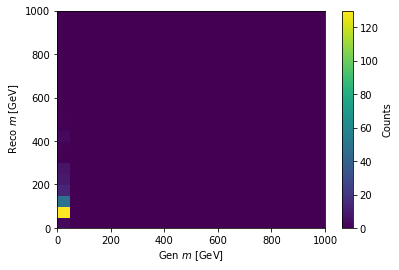

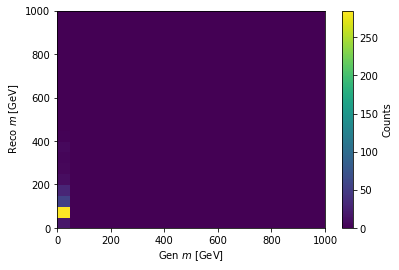

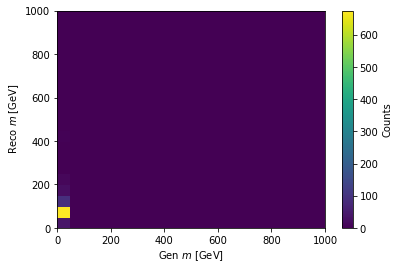

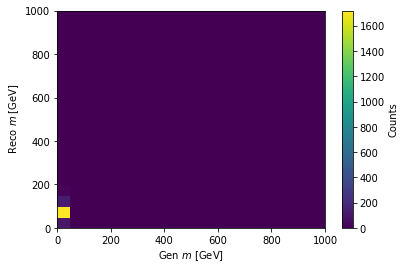

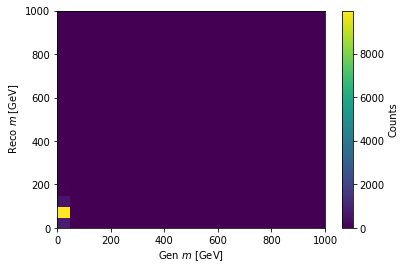

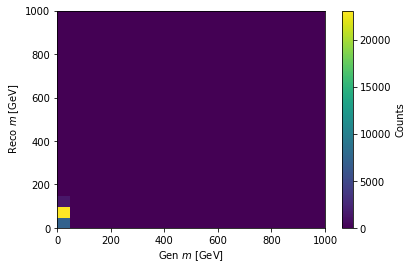

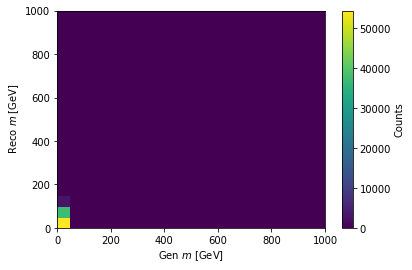

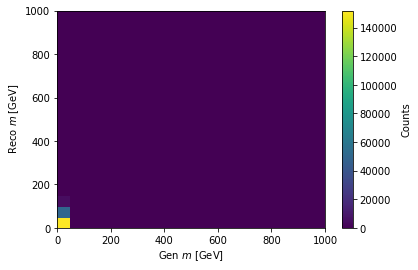

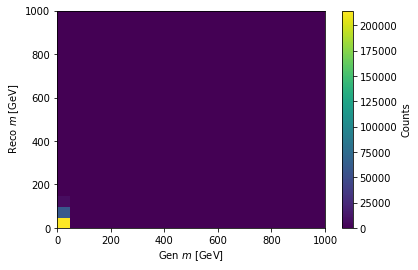

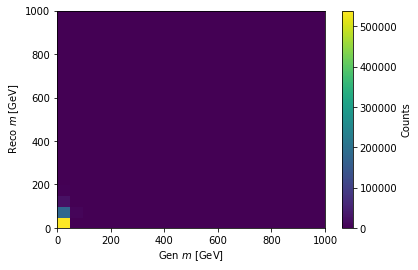

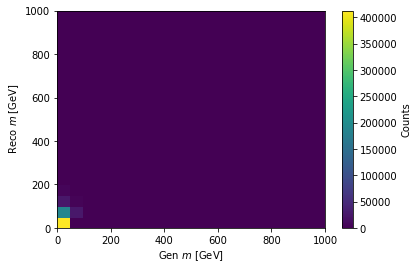

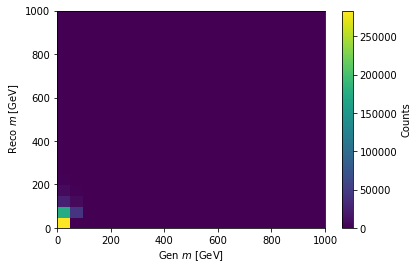

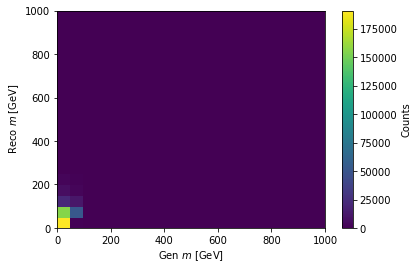

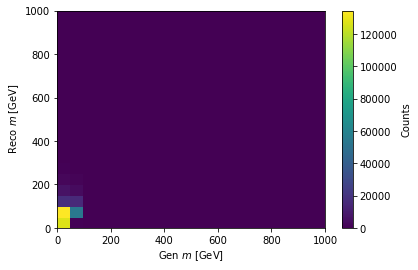

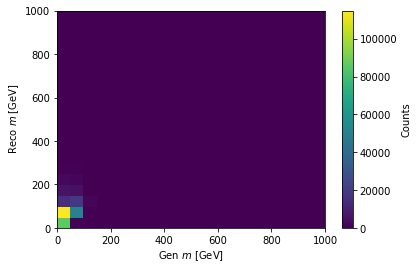

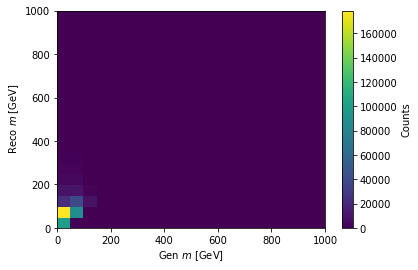

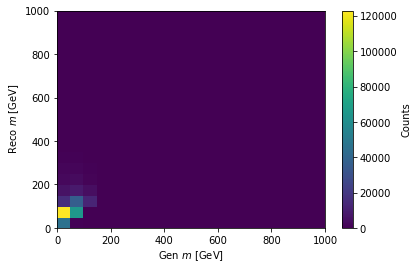

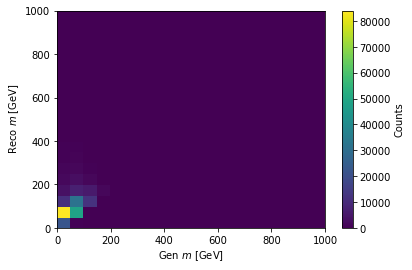

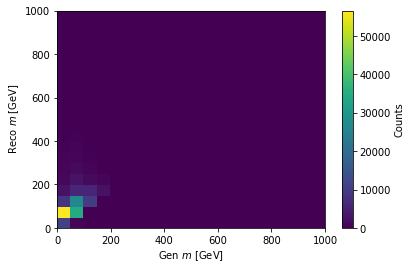

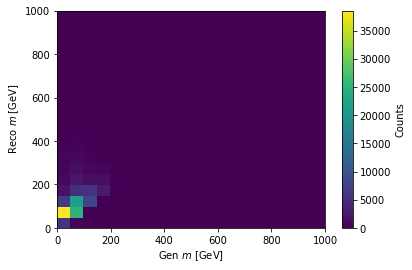

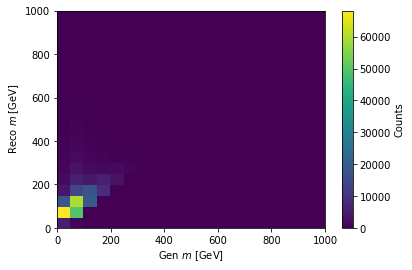

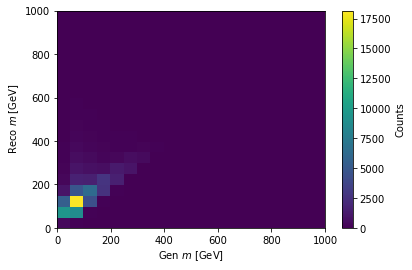

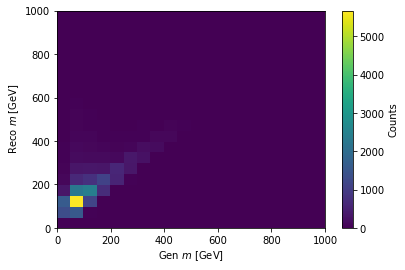

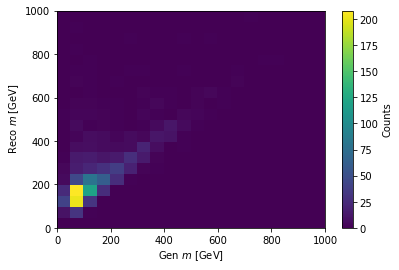

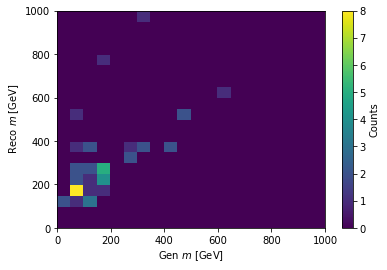

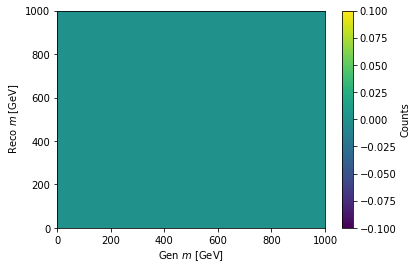

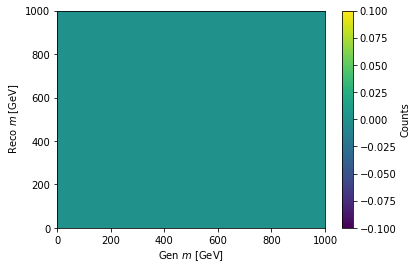

In [13]:
for i in output['h_response'].axis('pt_gen_axis'):
    fig, ax, _ = hist.plot2d(output['h_response'].sum('dataset','pt_reco_axis').integrate('pt_gen_axis', i),xaxis='m_gen_axis')
    

IndexError: index 1 is out of bounds for axis 0 with size 1

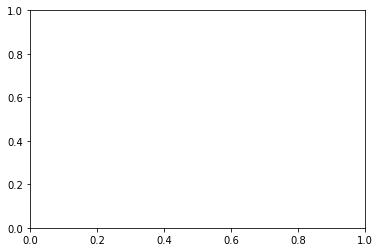

In [11]:
hist.plot2d(output['h_2dresponse'].sum('dataset'), xaxis='gen_axis');

In [ ]:
#Use Hist.group to conver h_response to h_2dresponse --> what is my mapping?